Workbook to tidy ESG data.

* Deshift ESG data
* Create sector index

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
from pandas_datareader import data
from util import fetch_raw_data


fetch data, remove ESG scores where there are less than 20 data points.

In [3]:
price_pivot, esg_pivot, sector_classification = fetch_raw_data("C:/Users/User/Code/MMD_Graph_Diversification/")

2014-10-01 00:00:00
2022-02-01 00:00:00


Predefine functions

In [3]:
def build_sector_index(marketcap, esg_data):
    index_dict = dict()
    mcap_dict = dict()

    # esg_data['CRM'].iloc[2008:2090] = np.nan

    all_observed = dict()

    # fill na with previous value
    esg_data_ffil = esg_data.fillna(method='ffill').copy()

    for k, v in sector_classification.items():

        index_dict[k] = np.zeros(esg_data.shape[0])
        mcap_dict[k] = np.zeros((esg_data.shape[0], len(v)))

        all_observed[k] = np.array(~esg_data.loc[:, np.isin(esg_data.columns, v)].isna().all(axis=1))
        
        for idx, ticker in enumerate(v):
            if not np.isin(ticker, esg_data_ffil.columns):
                continue

            
            tmp = np.array(esg_data_ffil[ticker])
            tmp[np.isnan(esg_data_ffil[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            tmp_mcap = np.zeros(index_dict[k].shape[0])
            tmp_mcap[np.isfinite(esg_data_ffil[ticker])] = np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            mcap_dict[k][:,idx] = tmp_mcap.copy()

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan
        mcap_sum = np.sum(mcap_dict[k], axis =1)
        index_dict[k] = index_dict[k]/mcap_sum




    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()

    return index_dict, mcap_dict, all_observed





def plot_esg_industry(sector:str, asset_profiles:pd.DataFrame, esg_data:pd.DataFrame):
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))
        
    for idx, industry in enumerate(industries):

        j = idx % 4
        i = int(np.floor(idx/4)) 
        
        companies_in_industry = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])
        axs[i,j].set_title(industry)
        if np.sum(esg_data.columns.isin(companies_in_industry)) == 0:
            print(f'No esg data on companies in industry {industry}')
            continue
        companies = esg_data.loc[:, esg_data.columns.isin(companies_in_industry)]

        for ticker in companies.columns:
            
            y = esg_data[ticker]
            ymask = np.isfinite(y)
            x = esg_data.index[ymask]
            axs[i,j].plot(x, y[ymask], alpha = 0.4)

def find_jump(y):
    """

    find the index where the biggest jump of a ESG score happens
    
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction

How many companies do we have data for each sector?

In [4]:
for k,v in sector_classification.items():
    print(f'{k} {len(v)}')

Industrials 71
Healthcare 66
Technology 72
Communication Services 24
Consumer Defensive 34
Consumer Cyclical 64
Utilities 29
Financial Services 68
Basic Materials 21
Real Estate 30
Energy 21


<AxesSubplot:xlabel='date'>

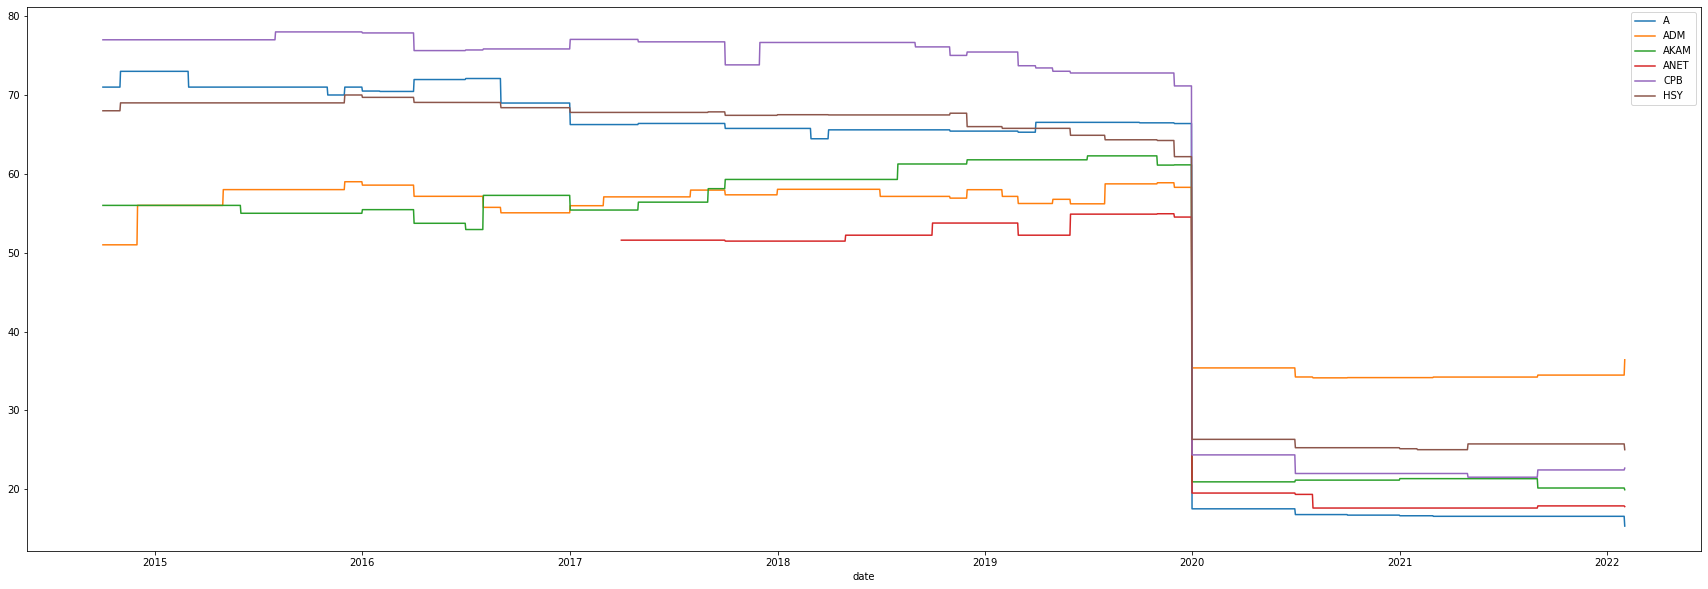

In [5]:
esg_pivot.iloc[:, [0,10,20,30,100,200]].ffill().plot(figsize = (30,10))

Remove the shift

In [12]:
esg_pivot_shifted = esg_pivot.copy()

for stock in esg_pivot.columns:
    y_tmp = np.expand_dims(esg_pivot.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted[stock].iloc[:index] = np.nanmedian(esg_pivot[stock].iloc[index:]) - np.nanmedian(esg_pivot[stock].iloc[:index]) + esg_pivot[stock].iloc[:index]


<AxesSubplot:xlabel='date'>

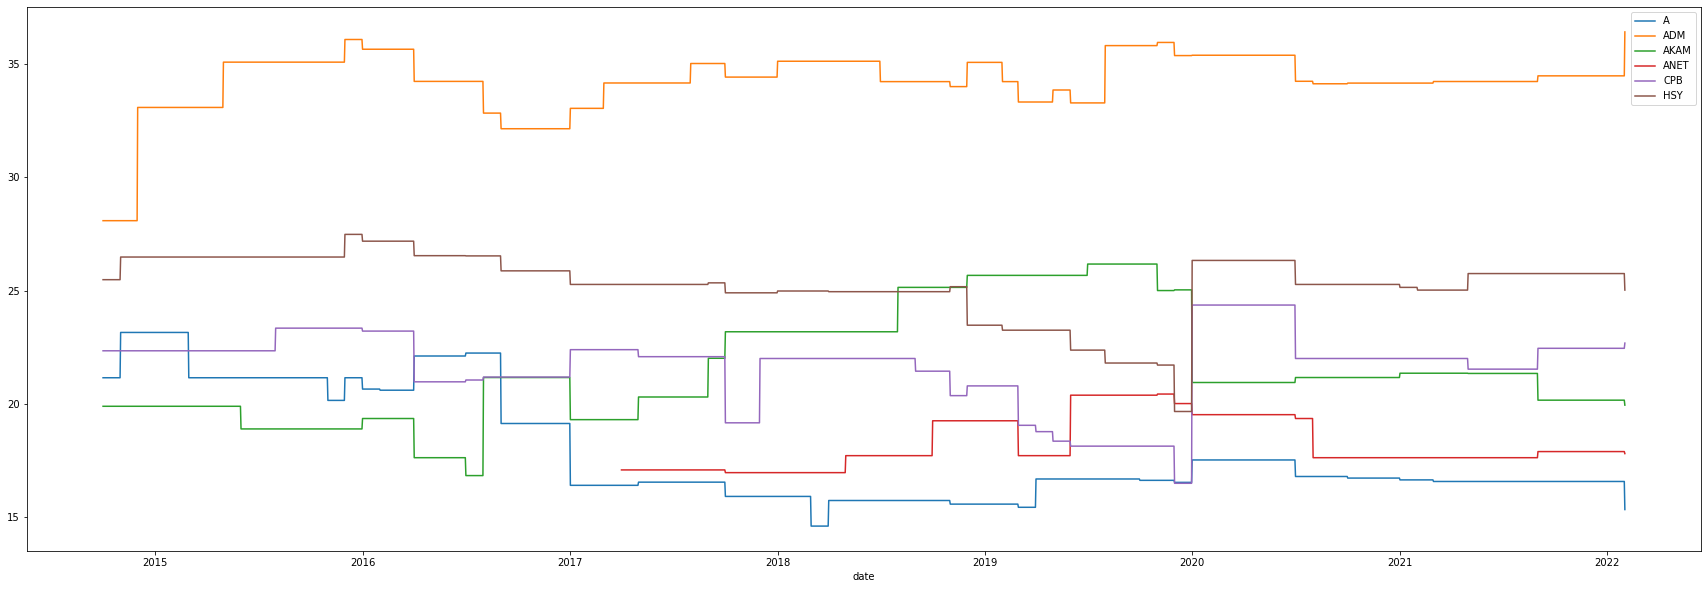

In [17]:
esg_pivot_shifted.iloc[:, [0,10,20,30,100,200]].ffill().plot(figsize = (30,10))

Save data

In [19]:

with open('data/tidy/esg_refined_no_diff.pkl', 'wb') as handle:
    pickle.dump(esg_pivot_shifted, handle, protocol=pickle.HIGHEST_PROTOCOL)

Next create market cap weighted ESG index. This will not be same as when the paper was made as the the current date is not the same

In [27]:
# for loop to see which company fails
marketcap = pd.DataFrame()
for ticker in list(esg_pivot_shifted.columns):
    try:
        tmp_mcap = data.get_quote_yahoo(ticker)['marketCap']
        # print(tmp_mcap)
        marketcap  = pd.concat([marketcap, pd.DataFrame({"ticker":ticker, "marketcap":tmp_mcap[0]/1000_000}, index=[0])], ignore_index = True)
    except:
        print(f"{ticker} failed") 

ANTM failed
BLL failed
CERN failed
FB failed


have to manually add failed cap

In [30]:

#marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'FB', "marketcap":477.01*1000_000_000/1000_000}, index=[0])] )

In [37]:
index_dict, market_cap_sum,all_observed = build_sector_index(marketcap, esg_data = esg_pivot_shifted)

<AxesSubplot:xlabel='date'>

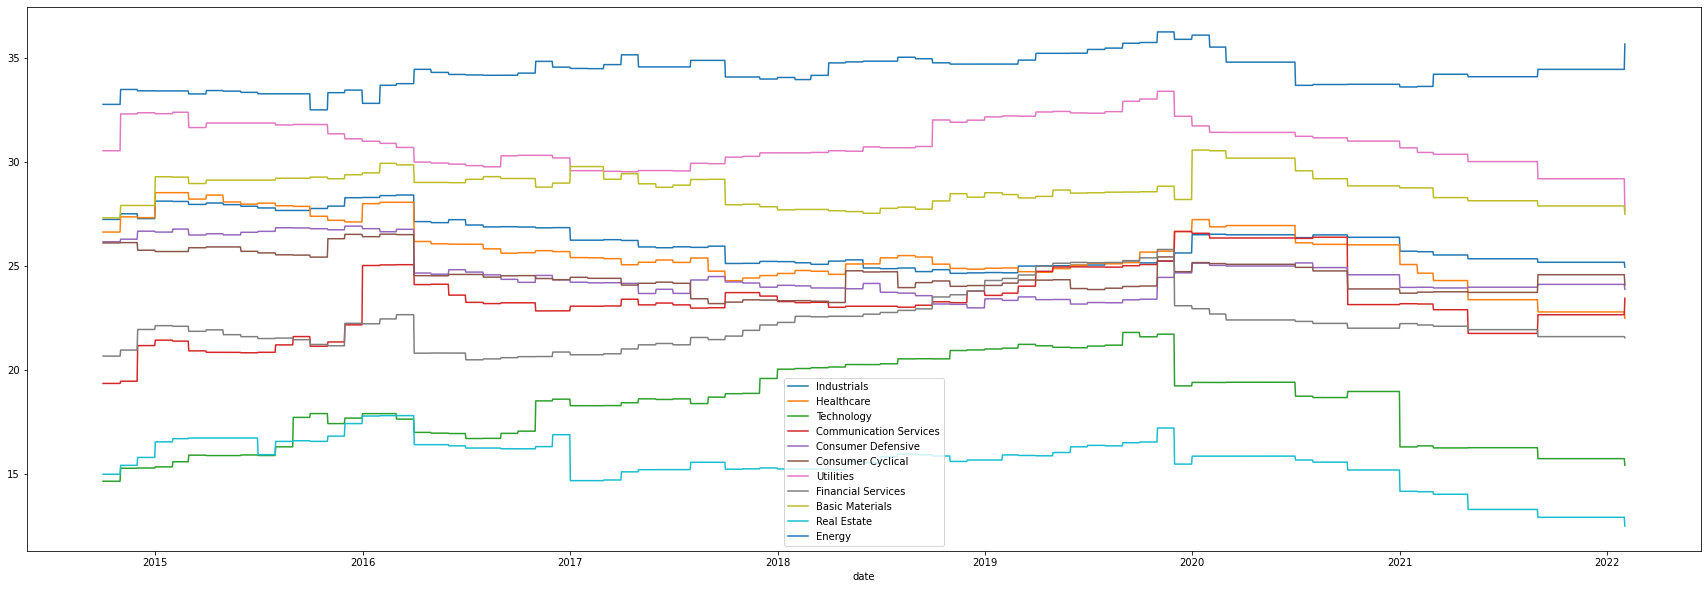

In [40]:
index_dict.plot(figsize = (30,10))

In [43]:
index_dict_pkl = dict(data = index_dict, index = all_observed)
with open('data/tidy/sector_index_no_diff.pkl', 'wb') as handle:
    pickle.dump(index_dict_pkl, handle)